Running on CPU with GPU disabled.
Running minimal prediction test...


/Users/tkarim45/miniforge3/envs/personal/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model loaded for test.
Predicting with dummy input...
Prediction shape: (1, 256, 256, 1)
Test completed successfully.
Checking model path: /Users/tkarim45/Documents/Personal Github Repositories/CureWise-AI-Medical-Healthcare/backend/data/Breast Cancer/Model/Breast Cancer.h5
Checking image path: /Users/tkarim45/Documents/Personal Github Repositories/CureWise-AI-Medical-Healthcare/backend/data/Breast Cancer/Data/malignant/malignant (101).png
Loading model...


Model loaded successfully.
Model recompiled.
Loading image: /Users/tkarim45/Documents/Personal Github Repositories/CureWise-AI-Medical-Healthcare/backend/data/Breast Cancer/Data/malignant/malignant (101).png
Image loaded and resized to 256x256
Input image shape: (1, 256, 256, 3)
Making prediction...
Prediction completed.
Model memory cleared.
Generating visualizations...


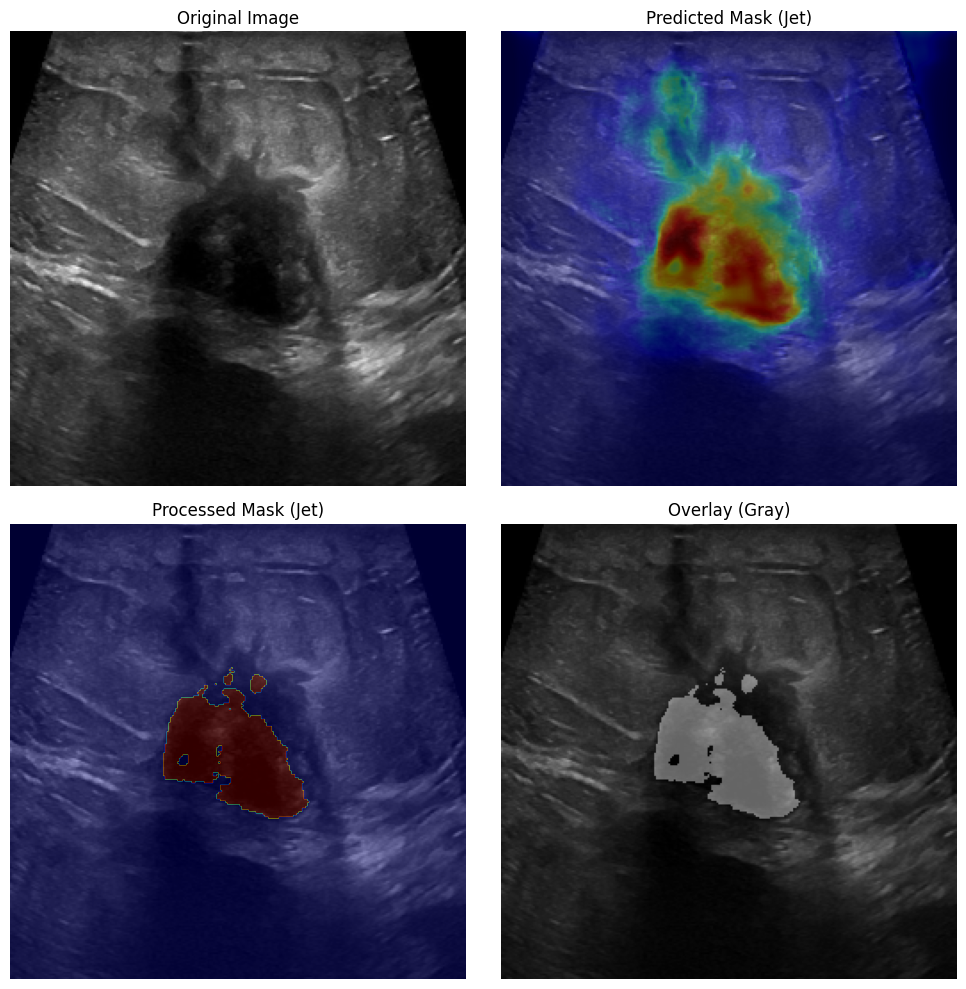

Visualizations displayed.
Memory cleared.


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.image as tfi
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from keras.layers import Layer, Conv2D, Dropout, UpSampling2D, concatenate, Add, Multiply, Input, MaxPool2D, BatchNormalization
from keras.metrics import MeanIoU
import os
import gc
import sys

# Force CPU usage and disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Disable CUDA GPUs
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'  # Prevent GPU memory allocation
os.environ['TF_MLIR_ENABLE_CONVERSION'] = '0'  # Disable MLIR optimizations
tf.config.set_visible_devices([], 'GPU')  # Explicitly hide GPUs
print("Running on CPU with GPU disabled.")

# Define custom layers
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()
    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, 'rate':self.rate, 'pooling':self.pooling}

class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)
    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, 'rate':self.rate}

class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters
        self.bn = bn
        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()
    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "bn":self.bn}

# Define utility functions
def load_image(image_path, SIZE):
    """Load and preprocess a single image."""
    try:
        print(f"Loading image: {image_path}")
        img = load_img(image_path)
        img_array = img_to_array(img) / 255.0
        resized = np.round(tfi.resize(img_array, (SIZE, SIZE)), 4)
        print(f"Image loaded and resized to {SIZE}x{SIZE}")
        return resized
    except Exception as e:
        raise FileNotFoundError(f"Failed to load image at {image_path}: {e}")

def show_image(image, title=None, cmap=None, alpha=1):
    """Display an image."""
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    """Display an image with a mask overlay."""
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

# Modified predict_and_visualize function
def predict_and_visualize(image_path, model_path, mask_path=None, SIZE=256, visualize=True):
    """
    Make predictions for an image and optionally visualize the results.
    
    Parameters:
    - image_path: Path to the input image.
    - model_path: Path to the saved model (.h5 file).
    - mask_path: (Optional) Path to the ground truth mask for comparison.
    - SIZE: Image size for preprocessing (default: 256).
    - visualize: Whether to display visualizations (default: True).
    """
    # Check file paths
    print(f"Checking model path: {model_path}")
    if not model_path or not os.path.exists(model_path):
        raise ValueError(f"Model file not found at: {model_path}. Please provide a valid .h5 model file.")
    print(f"Checking image path: {image_path}")
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at: {image_path}.")

    # Load the model
    try:
        print("Loading model...")
        tf.keras.backend.clear_session()  # Clear previous session
        model = load_model(model_path, custom_objects={
            'EncoderBlock': EncoderBlock,
            'DecoderBlock': DecoderBlock,
            'AttentionGate': AttentionGate,
            'MeanIoU': MeanIoU
        })
        print("Model loaded successfully.")
        # Recompile the model
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
        )
        print("Model recompiled.")
    except Exception as e:
        raise ValueError(f"Failed to load model from {model_path}: {e}")

    # Load and preprocess the image
    image = load_image(image_path, SIZE)
    image_batch = image[np.newaxis, ...]  # Add batch dimension
    print(f"Input image shape: {image_batch.shape}")

    # Predict the mask
    try:
        print("Making prediction...")
        pred_mask = model.predict(image_batch, batch_size=1, verbose=0)[0]
        pred_mask_processed = (pred_mask > 0.5).astype('float')
        print("Prediction completed.")
    except Exception as e:
        raise RuntimeError(f"Prediction failed: {e}")
    finally:
        # Clear model from memory
        del model
        gc.collect()
        tf.keras.backend.clear_session()
        print("Model memory cleared.")

    # Load ground truth mask if provided
    ground_truth_mask = None
    if mask_path:
        try:
            print(f"Loading ground truth mask: {mask_path}")
            ground_truth_mask = load_image(mask_path, SIZE)[:, :, :1]
            print("Ground truth mask loaded.")
        except Exception as e:
            print(f"Warning: Failed to load ground truth mask at {mask_path}: {e}")
            ground_truth_mask = None

    if not visualize:
        print("Skipping visualizations as requested.")
        return

    # Visualizations
    try:
        print("Generating visualizations...")
        plt.figure(figsize=(10, 10))
        
        # Row 1: Original Image and Predicted Mask (Jet)
        plt.subplot(2, 2, 1)
        plt.title("Original Image")
        show_image(image)
        
        plt.subplot(2, 2, 2)
        plt.title("Predicted Mask (Jet)")
        show_mask(image, pred_mask, cmap='jet')
        
        # Row 2: Processed Mask (Jet) and Overlay (Gray)
        plt.subplot(2, 2, 3)
        plt.title("Processed Mask (Jet)")
        show_mask(image, pred_mask_processed, cmap='jet')
        
        plt.subplot(2, 2, 4)
        plt.title("Overlay (Gray)")
        show_image(image)
        plt.imshow(pred_mask_processed[:, :, 0], cmap='gray', alpha=0.4)
        
        plt.tight_layout()
        plt.show()
        print("Visualizations displayed.")
    except Exception as e:
        print(f"Warning: Visualization failed: {e}")
    finally:
        # Clear memory
        plt.close('all')
        gc.collect()
        print("Memory cleared.")

# Minimal test function for prediction
def test_prediction(model_path, SIZE=256):
    """Test model prediction with a dummy input to isolate issues."""
    try:
        print("Running minimal prediction test...")
        tf.keras.backend.clear_session()
        model = load_model(model_path, custom_objects={
            'EncoderBlock': EncoderBlock,
            'DecoderBlock': DecoderBlock,
            'AttentionGate': AttentionGate,
            'MeanIoU': MeanIoU
        })
        print("Model loaded for test.")
        dummy_input = np.random.rand(1, SIZE, SIZE, 3).astype(np.float32)
        print("Predicting with dummy input...")
        pred = model.predict(dummy_input, batch_size=1, verbose=0)
        print(f"Prediction shape: {pred.shape}")
        del model
        gc.collect()
        tf.keras.backend.clear_session()
        print("Test completed successfully.")
    except Exception as e:
        print(f"Test failed: {e}")

# Example usage
image_path = '/Users/tkarim45/Documents/Personal Github Repositories/CureWise-AI-Medical-Healthcare/backend/data/Breast Cancer/Data/malignant/malignant (101).png'
model_path = '/Users/tkarim45/Documents/Personal Github Repositories/CureWise-AI-Medical-Healthcare/backend/data/Breast Cancer/Model/Breast Cancer.h5'
mask_path = None  # Optional

# First, run the minimal test
try:
    test_prediction(model_path, SIZE=256)
except Exception as e:
    print(f"Minimal test error: {e}")

# Then, run full prediction
try:
    predict_and_visualize(image_path, model_path, mask_path, SIZE=256, visualize=True)
except Exception as e:
    print(f"Error: {e}")
